In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import requests

/Users/jordankesner/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [10]:
def getFinalPositions(session_key):
    """
    Get final race positions (1 per driver) using latest timestamp from /position.
    """
    url = f"https://api.openf1.org/v1/position?session_key={session_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception(f"Failed to fetch positions for session_key={session_key}")
    
    df = pd.DataFrame(response.json())
    if df.empty:
        print(f"No data for session {session_key}")
        return pd.DataFrame()

    # Fix: Use ISO8601 format when parsing dates
    df["date"] = pd.to_datetime(df["date"], format='ISO8601')

    # Get latest position for each driver
    df = df.sort_values("date")
    last_positions = df.groupby("driver_number").tail(1)  # ✅ Get only last row per driver

    return last_positions[["driver_number", "position", "date"]]


In [13]:
session_url = f"https://api.openf1.org/v1/sessions?year=2023"
sessions = pd.DataFrame(requests.get(session_url).json())
sessions.head()

,meeting_key,session_key,location,date_start,date_end,session_type,session_name,country_key,country_code,country_name,circuit_key,circuit_short_name,gmt_offset,year
0,1140,9222,Sakhir,2023-02-23T07:00:00+00:00,2023-02-23T16:30:00+00:00,Practice,Practice 1,36,BRN,Bahrain,63,Sakhir,03:00:00,2023
1,1140,7763,Sakhir,2023-02-24T07:00:00+00:00,2023-02-24T16:30:00+00:00,Practice,Practice 2,36,BRN,Bahrain,63,Sakhir,03:00:00,2023
2,1140,7764,Sakhir,2023-02-25T07:00:00+00:00,2023-02-25T16:30:00+00:00,Practice,Practice 3,36,BRN,Bahrain,63,Sakhir,03:00:00,2023
3,1141,7765,Sakhir,2023-03-03T11:30:00+00:00,2023-03-03T12:30:00+00:00,Practice,Practice 1,36,BRN,Bahrain,63,Sakhir,03:00:00,2023
4,1141,7766,Sakhir,2023-03-03T15:00:00+00:00,2023-03-03T16:00:00+00:00,Practice,Practice 2,36,BRN,Bahrain,63,Sakhir,03:00:00,2023


In [15]:

# Load driver metadata once
drivers = pd.DataFrame(
    requests.get("https://api.openf1.org/v1/drivers").json()
).drop_duplicates(subset="driver_number", keep="last")

all_race_data = []

# Loop through years
for year in range(2023, 2025):
    print(f"\n📅 Processing year {year}...")
    
    session_url = f"https://api.openf1.org/v1/sessions?year={year}"
    response = requests.get(session_url)

    try:
        session_json = response.json()
    except Exception as e:
        print(f"❌ Failed to decode JSON for year {year}: {e}")
        continue

    if not session_json:
        print(f"⚠️ No session data returned for year {year}")
        continue

    sessions = pd.DataFrame(session_json)

    if "session_type" not in sessions.columns:
        print(f"⚠️ 'session_type' column missing for year {year}, available columns: {sessions.columns.tolist()}")
        continue

    race_keys = sessions[sessions["session_type"] == "Race"]["session_key"].tolist()

    for key in race_keys:
        try:
            race = getFinalPositions(key)  # your earlier function

            if race.empty:
                print(f"  ⚠️ No position data for session {key}")
                continue

            race["session_key"] = key
            race["year"] = year

            # Merge with driver info
            race = race.merge(
                drivers[["driver_number", "full_name", "team_name"]],
                on="driver_number",
                how="left"
            )

            all_race_data.append(race)

        except Exception as e:
            print(f"  ❌ Failed on session {key}: {e}")

# Combine everything into one DataFrame
race_df = pd.concat(all_race_data, ignore_index=True)

# Optional: save to disk
race_df.to_csv("final_positions_2021_2024.csv", index=False)

print(f"\n✅ All done! Final shape: {race_df.shape}")



📅 Processing year 2023...
  ❌ Failed on session 9117: Failed to fetch positions for session_key=9117
  ❌ Failed on session 9117: Failed to fetch positions for session_key=9117
  ❌ Failed on session 9118: Failed to fetch positions for session_key=9118
  ❌ Failed on session 9118: Failed to fetch positions for session_key=9118
  ❌ Failed on session 9126: Failed to fetch positions for session_key=9126
  ❌ Failed on session 9126: Failed to fetch positions for session_key=9126
  ❌ Failed on session 9141: Failed to fetch positions for session_key=9141
  ❌ Failed on session 9141: Failed to fetch positions for session_key=9141
  ❌ Failed on session 9157: Failed to fetch positions for session_key=9157
  ❌ Failed on session 9157: Failed to fetch positions for session_key=9157
  ❌ Failed on session 9213: Failed to fetch positions for session_key=9213
  ❌ Failed on session 9213: Failed to fetch positions for session_key=9213
  ❌ Failed on session 9181: Failed to fetch positions for session_key=918

In [16]:
race_df

,driver_number,position,date,session_key,year,full_name,team_name
0,81,20,2023-03-05 15:27:44.849000+00:00,7953,2023,Oscar PIASTRI,McLaren
1,1,1,2023-03-05 15:33:28.905000+00:00,7953,2023,Max VERSTAPPEN,Red Bull Racing
2,11,2,2023-03-05 15:46:43.484000+00:00,7953,2023,Sergio PEREZ,Red Bull Racing
3,44,5,2023-03-05 16:10:15.084000+00:00,7953,2023,Lewis HAMILTON,Ferrari
4,18,6,2023-03-05 16:10:21.724000+00:00,7953,2023,Lance STROLL,Aston Martin
...,...,...,...,...,...,...,...
752,44,4,2024-12-08 14:30:45.324000+00:00,9662,2024,Lewis HAMILTON,Ferrari
753,63,5,2024-12-08 14:30:45.324000+00:00,9662,2024,George RUSSELL,Mercedes
754,22,12,2024-12-08 14:31:47.371000+00:00,9662,2024,Yuki TSUNODA,Red Bull Racing
755,18,14,2024-12-08 14:31:47.371000+00:00,9662,2024,Lance STROLL,Aston Martin


In [23]:
def getQualifyingPosition(session_key):
    """
    Get final qualifying positions for a given qualifying session_key.
    Returns a DataFrame with driver_number and qualifying_position.
    """
    url = f"https://api.openf1.org/v1/position?session_key={session_key}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"❌ Failed to get qualifying for session {session_key}")
        return pd.DataFrame()

    df = pd.DataFrame(response.json())
    if df.empty or "date" not in df.columns:
        return pd.DataFrame()

    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df = df.dropna(subset=["date"])
    latest_position = df.sort_values("date").groupby("driver_number").tail(1)
    latest_position = latest_position[["driver_number", "position"]]
    latest_position = latest_position.rename(columns={"position": "qualifying_position"})
    return latest_position


In [24]:
# Get session metadata so we can map qualifying -> race
sessions_all = pd.DataFrame(
    requests.get("https://api.openf1.org/v1/sessions").json()
)

# Map race session_keys to their meeting_keys
race_meetings = race_df[["session_key"]].drop_duplicates().merge(
    sessions_all[["session_key", "meeting_key", "session_type"]],
    on="session_key",
    how="left"
)

# Build race_key → qual_key mapping
race_to_qual = {}
for mk in race_meetings["meeting_key"].unique():
    sess_subset = sessions_all[sessions_all["meeting_key"] == mk]
    race_row = sess_subset[sess_subset["session_type"] == "Race"]
    qual_row = sess_subset[sess_subset["session_type"] == "Qualifying"]

    if not race_row.empty and not qual_row.empty:
        race_key = race_row["session_key"].values[0]
        qual_key = qual_row["session_key"].values[0]
        race_to_qual[race_key] = qual_key

# Pull qualifying positions and merge
qualifying_results = []

for race_key, qual_key in race_to_qual.items():
    qpos = getQualifyingPosition(qual_key)
    if not qpos.empty:
        qpos["session_key"] = race_key  # match to race session
        qualifying_results.append(qpos)

qual_df = pd.concat(qualifying_results, ignore_index=True)

# Merge into your race_df
race_df = race_df.merge(qual_df, on=["session_key", "driver_number"], how="left")


❌ Failed to get qualifying for session 9612
❌ Failed to get qualifying for session 9621
❌ Failed to get qualifying for session 9640
❌ Failed to get qualifying for session 9650
❌ Failed to get qualifying for session 9658


In [25]:
race_df.head()

,driver_number,position,date,session_key,year,full_name,team_name,qualifying_position
0,81,20,2023-03-05 15:27:44.849000+00:00,7953,2023,Oscar PIASTRI,McLaren,18.0
1,1,1,2023-03-05 15:33:28.905000+00:00,7953,2023,Max VERSTAPPEN,Red Bull Racing,1.0
2,11,2,2023-03-05 15:46:43.484000+00:00,7953,2023,Sergio PEREZ,Red Bull Racing,2.0
3,44,5,2023-03-05 16:10:15.084000+00:00,7953,2023,Lewis HAMILTON,Ferrari,7.0
4,18,6,2023-03-05 16:10:21.724000+00:00,7953,2023,Lance STROLL,Aston Martin,8.0


In [26]:
sessions_meta = pd.DataFrame(
    requests.get("https://api.openf1.org/v1/sessions").json()
)

# Filter down to just race sessions
race_sessions = sessions_meta[sessions_meta["session_type"] == "Race"]

# Keep only columns we care about
race_locations = race_sessions[["session_key", "circuit_short_name", "country_name"]]

# Merge into your main race_df
race_df = race_df.merge(race_locations, on="session_key", how="left")



In [27]:
race_df.head()

,driver_number,position,date,session_key,year,full_name,team_name,qualifying_position,circuit_short_name,country_name
0,81,20,2023-03-05 15:27:44.849000+00:00,7953,2023,Oscar PIASTRI,McLaren,18.0,Sakhir,Bahrain
1,1,1,2023-03-05 15:33:28.905000+00:00,7953,2023,Max VERSTAPPEN,Red Bull Racing,1.0,Sakhir,Bahrain
2,11,2,2023-03-05 15:46:43.484000+00:00,7953,2023,Sergio PEREZ,Red Bull Racing,2.0,Sakhir,Bahrain
3,44,5,2023-03-05 16:10:15.084000+00:00,7953,2023,Lewis HAMILTON,Ferrari,7.0,Sakhir,Bahrain
4,18,6,2023-03-05 16:10:21.724000+00:00,7953,2023,Lance STROLL,Aston Martin,8.0,Sakhir,Bahrain


In [28]:
race_df["winner"] = (race_df["position"] == 1).astype(int)


In [29]:
race_df.head()

,driver_number,position,date,session_key,year,full_name,team_name,qualifying_position,circuit_short_name,country_name,winner
0,81,20,2023-03-05 15:27:44.849000+00:00,7953,2023,Oscar PIASTRI,McLaren,18.0,Sakhir,Bahrain,0
1,1,1,2023-03-05 15:33:28.905000+00:00,7953,2023,Max VERSTAPPEN,Red Bull Racing,1.0,Sakhir,Bahrain,1
2,11,2,2023-03-05 15:46:43.484000+00:00,7953,2023,Sergio PEREZ,Red Bull Racing,2.0,Sakhir,Bahrain,0
3,44,5,2023-03-05 16:10:15.084000+00:00,7953,2023,Lewis HAMILTON,Ferrari,7.0,Sakhir,Bahrain,0
4,18,6,2023-03-05 16:10:21.724000+00:00,7953,2023,Lance STROLL,Aston Martin,8.0,Sakhir,Bahrain,0


In [30]:
def getWeatherSummary(session_key):
    """
    Fetch average weather stats for a race session.
    Returns a single-row DataFrame.
    """
    url = f"https://api.openf1.org/v1/weather?session_key={session_key}"
    response = requests.get(url)
    if response.status_code != 200:
        return None

    df = pd.DataFrame(response.json())
    if df.empty:
        return None

    # Keep only numeric weather fields
    weather_cols = ["air_temp", "track_temp", "humidity", "wind_speed", "rainfall"]
    df = df[[col for col in weather_cols if col in df.columns]]

    # Compute average per session
    summary = df.mean(numeric_only=True).to_frame().T
    summary["session_key"] = session_key
    return summary


In [31]:
weather_rows = []

for sk in race_df["session_key"].unique():
    result = getWeatherSummary(sk)
    if result is not None:
        weather_rows.append(result)

weather_df = pd.concat(weather_rows, ignore_index=True)

# Merge into race_df
race_df = race_df.merge(weather_df, on="session_key", how="left")


In [32]:
race_df.head()

,driver_number,position,date,session_key,year,full_name,team_name,qualifying_position,circuit_short_name,country_name,winner,humidity,wind_speed,rainfall
0,81,20,2023-03-05 15:27:44.849000+00:00,7953,2023,Oscar PIASTRI,McLaren,18.0,Sakhir,Bahrain,0,21.496894,0.68323,0.0
1,1,1,2023-03-05 15:33:28.905000+00:00,7953,2023,Max VERSTAPPEN,Red Bull Racing,1.0,Sakhir,Bahrain,1,21.496894,0.68323,0.0
2,11,2,2023-03-05 15:46:43.484000+00:00,7953,2023,Sergio PEREZ,Red Bull Racing,2.0,Sakhir,Bahrain,0,21.496894,0.68323,0.0
3,44,5,2023-03-05 16:10:15.084000+00:00,7953,2023,Lewis HAMILTON,Ferrari,7.0,Sakhir,Bahrain,0,21.496894,0.68323,0.0
4,18,6,2023-03-05 16:10:21.724000+00:00,7953,2023,Lance STROLL,Aston Martin,8.0,Sakhir,Bahrain,0,21.496894,0.68323,0.0


In [34]:
from sklearn.preprocessing import OneHotEncoder

# Select columns to encode
categorical_cols = ["team_name", "circuit_short_name", "full_name"]

# Create encoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Fit + transform
encoded = encoder.fit_transform(race_df[categorical_cols])

# Get encoded column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Join with original DataFrame
race_encoded = pd.concat([race_df.reset_index(drop=True), encoded_df], axis=1)

# Drop original categorical cols (optional)
race_encoded = race_encoded.drop(columns=categorical_cols)


In [36]:
race_encoded.head()

,driver_number,position,date,session_key,year,qualifying_position,country_name,winner,humidity,wind_speed,...,full_name_Max VERSTAPPEN,full_name_Maxwell ESTERSON,full_name_Nico HULKENBERG,full_name_Oscar PIASTRI,full_name_Pierre GASLY,full_name_Ryo HIRAKAWA,full_name_Sergio PEREZ,full_name_Valtteri BOTTAS,full_name_Yuki TSUNODA,full_name_ZHOU Guanyu
0,81,20,2023-03-05 15:27:44.849000+00:00,7953,2023,18.0,Bahrain,0,21.496894,0.68323,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2023-03-05 15:33:28.905000+00:00,7953,2023,1.0,Bahrain,1,21.496894,0.68323,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,2,2023-03-05 15:46:43.484000+00:00,7953,2023,2.0,Bahrain,0,21.496894,0.68323,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,44,5,2023-03-05 16:10:15.084000+00:00,7953,2023,7.0,Bahrain,0,21.496894,0.68323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,6,2023-03-05 16:10:21.724000+00:00,7953,2023,8.0,Bahrain,0,21.496894,0.68323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
race_encoded.columns

Index(['driver_number', 'position', 'date', 'session_key', 'year',
       'qualifying_position', 'country_name', 'winner', 'humidity',
       'wind_speed', 'rainfall', 'team_name_Alpine', 'team_name_Aston Martin',
       'team_name_Ferrari', 'team_name_Haas F1 Team', 'team_name_Kick Sauber',
       'team_name_McLaren', 'team_name_Mercedes', 'team_name_RB',
       'team_name_Racing Bulls', 'team_name_Red Bull Racing',
       'team_name_Williams', 'team_name_None', 'circuit_short_name_Austin',
       'circuit_short_name_Baku', 'circuit_short_name_Catalunya',
       'circuit_short_name_Hungaroring', 'circuit_short_name_Imola',
       'circuit_short_name_Interlagos', 'circuit_short_name_Jeddah',
       'circuit_short_name_Las Vegas', 'circuit_short_name_Lusail',
       'circuit_short_name_Melbourne', 'circuit_short_name_Mexico City',
       'circuit_short_name_Miami', 'circuit_short_name_Monte Carlo',
       'circuit_short_name_Montreal', 'circuit_short_name_Sakhir',
       'circuit_short_

In [37]:
drop_cols = ["position", "date", "session_key", "country_name", "full_name", "year"]
X = race_encoded.drop(columns=drop_cols + ["winner"], errors="ignore")
y = race_encoded["winner"]

In [41]:
from sklearn.model_selection import train_test_split
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
from sklearn.ensemble import RandomForestClassifier
# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Model accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       144
           1       0.71      0.62      0.67         8

    accuracy                           0.97       152
   macro avg       0.85      0.81      0.82       152
weighted avg       0.97      0.97      0.97       152



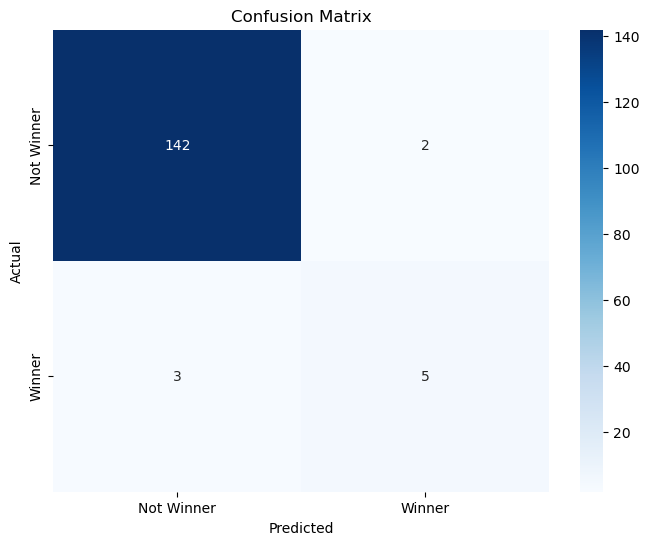

In [43]:
#evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Make predictions
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Winner", "Winner"],
            yticklabels=["Not Winner", "Winner"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [44]:
import numpy as np

probs = model.predict_proba(X_test)
top_3_preds = np.argsort(probs[:, 1])[::-1][:3]
actual_winner_index = np.where(y_test.values == 1)[0]

print("Top 3 predicted winners:", X_test.iloc[top_3_preds]["driver_number"].values)
print("Actual winner(s):", X_test.iloc[actual_winner_index]["driver_number"].values)


Top 3 predicted winners: [1 1 1]
Actual winner(s): [ 4  1 81  1  1  1  1 11]


In [45]:
importances = model.feature_importances_
feature_names = X.columns
top_features = sorted(zip(feature_names, importances), key=lambda x: -x[1])[:10]
for feat, imp in top_features:
    print(f"{feat}: {imp:.4f}")

qualifying_position: 0.1728
driver_number: 0.1662
full_name_Max VERSTAPPEN: 0.1620
wind_speed: 0.0840
humidity: 0.0708
team_name_Red Bull Racing: 0.0381
circuit_short_name_Baku: 0.0261
rainfall: 0.0244
circuit_short_name_Lusail: 0.0239
circuit_short_name_Yas Marina Circuit: 0.0159
